In [43]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

In [2]:
%matplotlib inline

# Read single NetCDF file
using the Xarray package: https://xarray.pydata.org/en/stable/

In [18]:
ds=xr.open_dataset('t2m/tas_Amon_CESM2-WACCM_ssp585_r1i1p1f1_gn_201501-210012.nc')

/Users/leo/anaconda3/lib/python3.6/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'tas' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  use_cftime=use_cftime,


In [19]:
ds.tas

<xarray.DataArray 'tas' (time: 1032, lat: 192, lon: 288)>
[57065472 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) object 2015-01-15 12:00:00 ... 2100-12-15 12:00:00
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    comment:        near-surface (usually, 2 meter) air temperature
    description:    near-surface (usually, 2 meter) air temperature
    frequency:      mon
    id:             tas
    long_name:      Near-Surface Air Temperature
    mipTable:       Amon
    out_name:       tas
    prov:           Amon ((isd.003))
    realm:          atmos
    standard_name:  air_temperature
    time:           time
    time_label:     time-mean
    time_title:     Temporal mean
    title:          Near-Surface Air Temperature
    type:           real
    units:          K
    variable_id:    tas

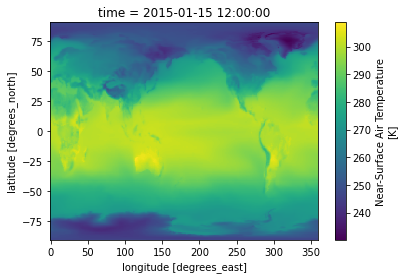

In [6]:
ds.tas[0].plot()

# Read multiple files at once
Use this when reading multiple time series of the same variable

https://xarray.pydata.org/en/stable/io.html?reading-multi-file-datasets

In [20]:
ds=xr.open_mfdataset('t2m/tas_Amon_*.nc',combine='by_coords')

# Antarctica mask

In [31]:
ds2 = xr.open_dataset('cam_LANDFRAC.nc')

In [44]:
landfrac = ds2.LANDFRAC.squeeze()

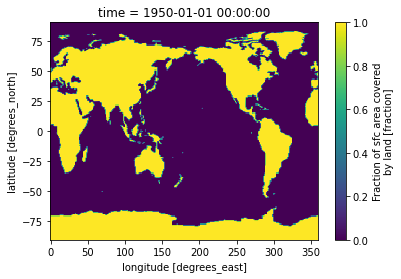

In [45]:
landfrac.plot()

In [46]:
lon = ds.lon
lat = ds.lat
lon2d, lat2d = np.meshgrid(lon,lat)

In [70]:
ais_mask = xr.where(lat2d<-60., landfrac, 0)
ais_mask.name = 'AIS_MASK'
ais_mask = ais_mask.reset_coords('time', drop=True) # drop time dimension

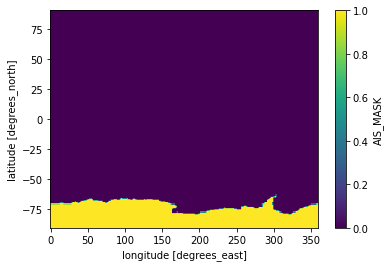

In [71]:
ais_mask.plot()

# Time series of mean annual temperature over AIS
To calculate a area-weighted mean temperature, we need to know what is the area of AIS. For this we read the `areacella` variable. 

In [87]:
ds_area = xr.open_dataset('fx/areacella_fx_CESM2-WACCM_ssp585_r1i1p1f1_gn.nc')
area = ds_area.areacella

/Users/leo/anaconda3/lib/python3.6/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'areacella' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  use_cftime=use_cftime,


In [88]:
total_area_AIS = (ais_mask * area).sum().item()
print(total_area_AIS, area.units)

14162570772480.0 m2


### Step 1: convert monthly to annual data

In [83]:
# days per month, assuming no leap years
dpm = np.array((31 ,28 ,31 ,30 ,31 ,30 ,31 ,31 ,30 ,31 ,30 ,31 )) 


def mul_with_dpm(data):
    """
    This helper function multiplies a monthly array (e.g. Xarray DataArray) with the number
    of days per month, and then divides by the total of days in the year. 
    """
    return (data * dpm[:,np.newaxis,np.newaxis]).sum(dim='time') / dpm.sum()

def monthly_to_yearly(data):
    """
    This function converts a 'timeseries' of monthly data to a timeseries of yearly data. 
    An approximation to this function is: 
    
        data.groupby('time.year').mean()
        
    But that doesn't take into account the different lengths of the months. 

    NOTE:
        This function assumes a 365-day calendar for each year (no leap, as is common in climate models).
    """
    out = data.groupby('time.year').apply(mul_with_dpm)
    out.attrs = data.attrs
    return out

Convert monthly data into annual data using either:
* Method 1: simple grouping per year
* Method 2: weighing the number of days per month

These methods will give a comparable, but slightly different answer. Let's go with method 2 since it's more accurate. 

In [116]:
#t2m_ann = ds.tas.groupby('time.year').mean() # Method 1
t2m_ann = monthly_to_yearly(ds.tas) # Method 2

In [117]:
t2m_ann.shape

(86, 192, 288)

### Step 2: calculate AIS average

In [119]:
t2m_ann_ais = (t2m_ann * ais_mask.values * area).sum(dim=['lat','lon'])/total_area_AIS

In [120]:
t2m_ann_ais.load();

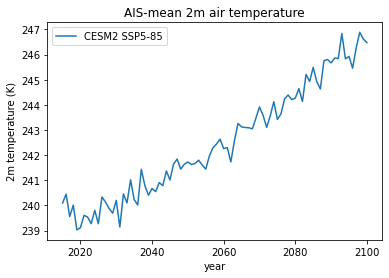

In [121]:
t2m_ann_ais.plot(label='CESM2 SSP5-85')
plt.title('AIS-mean 2m air temperature')
plt.ylabel('2m temperature (K)');
plt.legend()